In [1]:
from pixell import enmap,utils, reproject, enplot, bunch


import numpy as np
import matplotlib.pyplot as plt
import os,sys
from scipy.interpolate import interp1d
from scipy import interpolate
import math
import pandas as pd
import pickle as pk
import h5py

import time
import sqlite3 as sql
from pathlib import Path

%matplotlib inline
from astropy import wcs
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from astropy.io import fits
from astropy.table import QTable
import astropy.table as tb 
from astropy.time import Time 
#from astroquery.jplhorizons import Horizons

#import ephem

import re
from numba import jit

from asteroid_utils_pixell import minorplanet, get_desig, QueryHorizons, compute_alpha

%load_ext autoreload
%autoreload 2

[nia-jupyter.scinet.local:257146] pml_ucx.c:285  Error: UCP worker does not support MPI_THREAD_MULTIPLE


## Get designations by name here

In [2]:
name = 'Egeria'

with open('asteroids.pk', 'rb') as f:
        #open the pickle that contains all this info. You can also do this via querries to MPL but there's no 
        #internet on compute nodes so I saved all the relevant stuff
        df = pk.load(f)

#Find the index (not MPL designation) where the asteroid name array == name
idx = np.where((df['name'] == name))[0]

#Return the designation by indexing the designation array at the same spot
desig = df['designation'][idx]
print(desig)

34    13
Name: designation, dtype: object


## Make stacks here

In [3]:
desig, name, semimajor = get_desig(1)
print(name)

ast = minorplanet(name, semimajor)


Ceres


In [4]:
with open('bad_pointing_ranges.txt', 'rb') as f:
    bad_times = np.loadtxt(f)

In [5]:
with open('calibs_dict_ACTxACT-dr4.pkl', 'rb') as f:
     dr6_calib = pk.load(f)
calib_dict = {'pa4':{'150':dr6_calib['dr6_pa4_f150']['calibs'], '220':dr6_calib['dr6_pa4_f220']['calibs']},
              'pa5':{'090':dr6_calib['dr6_pa5_f090']['calibs'], '150':dr6_calib['dr6_pa5_f150']['calibs']},
              'pa6':{'090':dr6_calib['dr6_pa6_f090']['calibs'], '150':dr6_calib['dr6_pa6_f150']['calibs']}
             }

In [6]:
calib_dict = {'pa4': {'150': [1.0072175262677963, 0.0023154207035651023],
  '220': [1.0340185610989223, 0.01626333139583416]},
 'pa5': {'090': [1.0218836321586204, 0.0011691303344386838],
  '150': [0.9876564792184743, 0.001704546067935355]},
 'pa6': {'090': [1.0181628559678786, 0.0013096342890986763],
  '150': [0.9699498005405339, 0.002141045797557799]}} #Hardcoded for posterity

In [10]:
freq_dict = {'pa4':{'150':148.7e9, '220':227.2e9},
             'pa5':{'090':96.7e9,  '150':149.5e9},
             'pa6':{'090':95.5e9,  '150':148.1e9}}#Effective centers from Hasslefield paper 2022 in prep



ast.make_stack(pa = 'pa7', freq= '030', weight_type = 'paper_weight', plot = True, verbose = True, 
               lightcurve = True, freq_adjust = freq_dict, extern_calib = calib_dict, time_cut = bad_times)

#ast.make_all_stacks(weight_type = 'paper_weight', pol="U", plot = False, verbose = True, weight_debug = False,
#                    lightcurve = True, freq_adjust = freq_dict, extern_calib = calib_dict, time_cut = bad_times)


In map:  Ceres_depth1_1599264036_pa7_f030_kappa.fits


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/scratch/r/rbond/jorlo/actxminorplanets/sigurd/asteroids/Ceres/Ceres_depth1_1599264036_pa7_f030_info.hdf', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
ast.fluxes_lc


In [40]:
ast.flux_dict["night"]

{'pa4': {'150': {'flux': 43.211276943296696, 'var': 8.764622098749873},
  '220': {'flux': 77.24006955950252, 'var': 19.125386414990714}},
 'pa5': {'090': {'flux': 9.315560582384517, 'var': 4.441034052753097},
  '150': {'flux': 37.374490546171174, 'var': 5.676929412550563}},
 'pa6': {'090': {'flux': 19.66584709421736, 'var': 5.166814139324637},
  '150': {'flux': 34.415546101025186, 'var': 6.940655361142353}}}

In [33]:
#katherine_dict = {}

ast.flux_dict["night"]
#ast.flux_dict

{'pa4': {'150': {'flux': 475.33109906901285, 'var': 82.70302543351526},
  '220': {'flux': 1038.3608428122334, 'var': 204.75803182398698}},
 'pa5': {'090': {'flux': 118.87498246821302, 'var': 42.53841033996333},
  '150': {'flux': 411.49512101462557, 'var': 55.77492611786769}},
 'pa6': {'090': {'flux': 299.4526484642099, 'var': 55.161449341469456},
  '150': {'flux': 500.8296501519198, 'var': 80.58625038855749}}}

In [84]:
ast.flux_dict["night"]


{'pa4': {'150': {'flux': 379.6139801069542, 'var': 23.864236163446634},
  '220': {'flux': 897.7764417876348, 'var': 39.75460235558757}},
 'pa5': {'090': {'flux': 189.2696876851485, 'var': 11.071772625282568},
  '150': {'flux': 388.72673542550734, 'var': 13.877324502731131}},
 'pa6': {'090': {'flux': 169.7490236618519, 'var': 16.216104586705864},
  '150': {'flux': 354.08051701074135, 'var': 20.05404715144583}}}

In [88]:
pa = "pa6"
freq = "150"

with open('/project/r/rbond/jorlo/actxminorplanets/Eunomia_lc_night_{}_{}.pk'.format(pa, freq), 'rb') as f:
          old_flux_dict = pk.load(f)

np.sum(np.array(old_flux_dict['flux'])*np.array(old_flux_dict['F']))/len(old_flux_dict['flux'])

flux_stack = 0

for i in range(len(old_flux_dict['flux'])):
    flux_stack += np.array(old_flux_dict['flux'][i])*np.array(old_flux_dict['F'][i])
print(flux_stack/i)

451.19709043781023


In [113]:
with open('/scratch/r/rbond/jorlo/actxminorplanets/sigurd/lightcurves/Eunomia_paper_weight_lc_night_{}_{}.pk'.format(pa, freq), 'rb') as f:
          old_flux_dict = pk.load(f)

np.sum(np.array(old_flux_dict['flux'])*np.array(old_flux_dict['F']))/len(old_flux_dict['flux'])

435.87840391527453

In [68]:
colombi1_cmap = ListedColormap(np.loadtxt("~/Planck_FreqMap_RGB.txt")/255.)

plt.imshow(ast.map_dict['night']['pa5']['090']['flux'], cmap = colombi1_cmap)

#plt.title('PA')
plt.axis('off')
#plt.colorbar()
plt.savefig('./plots/example_stack.pdf', dpi=300)

NameError: name 'ListedColormap' is not defined

In [15]:
ast.make_all_stacks(weight_type = 'spt', lightcurve=True)#, time_debug = True, verbose = True)


Bad Tile: S/n
Bad Tile: S/n
Bad Tile: S/n
Bad Tile: S/n
day pa6 090
day pa6 150
Flux dict written for  Iris


In [22]:
with open('/home/r/rbond/jorlo/backup_vesta_flux_dict.pk', 'rb') as f:
          old_flux_dict = pk.load(f)

In [16]:
ast.flux_dict

{'day': {'pa4': {'150': {'flux': 1457.7758474840539, 'var': 46.14255208877651},
   '220': {'flux': 2328.1143464921915, 'var': 73.59905954425236}},
  'pa5': {'090': {'flux': 707.95758085011, 'var': 20.72758876771703},
   '150': {'flux': 1375.5476521132805, 'var': 25.068521173383516}},
  'pa6': {'090': {'flux': 661.0657424412991, 'var': 54.04662811621815},
   '150': {'flux': 1436.9693680129276, 'var': 65.801920638148}}},
 'night': {'pa4': {'150': {'flux': 1581.115715850995,
    'var': 18.138553069583843},
   '220': {'flux': 3164.5806094434533, 'var': 31.883617884763822}},
  'pa5': {'090': {'flux': 717.9235591613402, 'var': 8.46029891871647},
   '150': {'flux': 1569.5969166647858, 'var': 10.496958952355254}},
  'pa6': {'090': {'flux': 662.4982953452991, 'var': 20.43353084779451},
   '150': {'flux': 1399.3681766276327, 'var': 25.81388102857598}}}}

In [23]:
old_flux_dict

{'day': {'pa4': {'150': {'flux': array(1453.5155, dtype=float32),
    'var': 46.62203873442747},
   '220': {'flux': array(2156.134, dtype=float32), 'var': 69.9159910402667}},
  'pa5': {'090': {'flux': array(693.3721, dtype=float32),
    'var': 20.752589904286296},
   '150': {'flux': array(1392.6399, dtype=float32),
    'var': 25.821882174269295}},
  'pa6': {'090': {'flux': array(678.4422, dtype=float32),
    'var': 55.46933192873669},
   '150': {'flux': array(1474.6886, dtype=float32),
    'var': 67.52767485996115}}},
 'night': {'pa4': {'150': {'flux': array(1572.7007, dtype=float32),
    'var': 18.223915866052902},
   '220': {'flux': array(2958.896, dtype=float32), 'var': 30.139491935943852}},
  'pa5': {'090': {'flux': array(702.8083, dtype=float32),
    'var': 8.375418809230165},
   '150': {'flux': array(1585.9152, dtype=float32),
    'var': 10.690590034659381}},
  'pa6': {'090': {'flux': array(679.2599, dtype=float32),
    'var': 20.960211310991117},
   '150': {'flux': array(1431.39

# Compare Light Curves

In [36]:
freq = '220'
pa = 'pa4'
name = "Bamberga"
with open('/scratch/r/rbond/jorlo/actxminorplanets/sigurd/lightcurves/{}_paper_weight_lc_{}_{}_{}.pk'.format(
          name, 'night', pa, freq), 'rb') as f:
    lc_new = pk.load(f)
#with open('/project/r/rbond/jorlo/actxminorplanets/{}_lc_{}_{}_{}.pk'.format(
#          name, 'night', pa, freq), 'rb') as f:
#    lc_old = pk.load(f)

Text(0.5, 0, 'Time (ctime)')

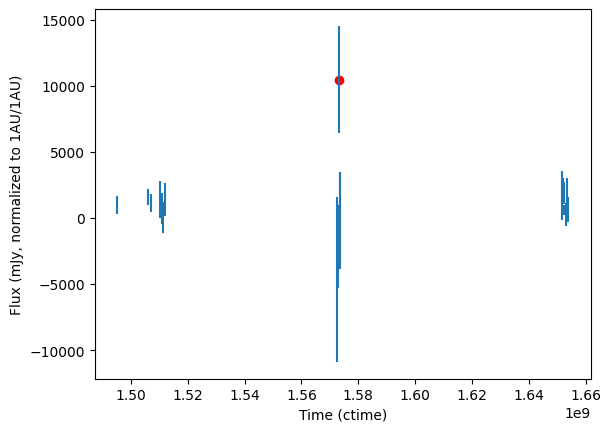

In [37]:
plt.errorbar(lc_new['time'], np.array(lc_new['flux'])*np.array(lc_new["F"]),
             yerr = np.array(lc_new['err'])*np.array(lc_new["F"]), linestyle = "None")
flags = np.where(((lc_new['flux'])*np.array(lc_new["F"])>3000))[0]
plt.scatter(np.array(lc_new['time'])[flags], (np.array(lc_new['flux'])*np.array(lc_new["F"]))[flags], color='r')
#plt.xscale("log")
plt.ylabel("Flux (mJy, normalized to 1AU/1AU)")
plt.xlabel("Time (ctime)")

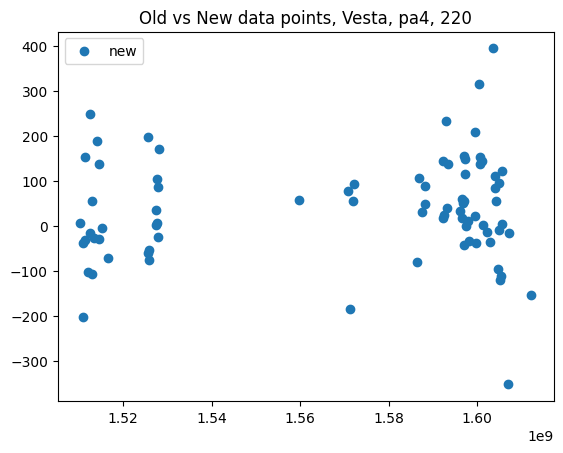

In [8]:
plt.scatter(lc_new['time'], lc_new['flux'], label = 'new')
#plt.scatter(lc_old['time'], lc_old['flux'], label = 'old')
plt.legend()
plt.title('Old vs New data points, Vesta, {}, {}'.format(pa, freq))
#plt.savefig('./plots/old_new_{}_{}.pdf'.format(pa, freq))
#plt.savefig('./plots/old_new_{}_{}.png'.format(pa, freq))
plt.show()
plt.close()

In [47]:
flags = np.where((np.abs((lc_new['flux'])*np.array(lc_new["F"]))<3000) )[0]
np.mean((np.array(lc_new['flux'])*np.array(lc_new["F"]))[flags])

380.6662368980215

In [27]:
stack = 0
numerator = 0
denominator = 0
for i in range(len(lc_new['flux'])):
    numerator += lc_new['rho'][i] * lc_new["F"][i] / lc_new['kappa'][i] #* lc_new["F"][i]**2
    denominator += 1#lc_new['kappa'][i] * lc_new["F"][i]**2
    #stack += lc_new['flux'][i] * np.array(lc_new["F"][i])
#print(stack/i)
print(numerator/denominator)
                            

352.19593549587603


In [26]:
flags = np.where(((lc_new['flux'])*np.array(lc_new["F"])>3000))[0]
np.array(lc_new['time'])[flags]
#np.array(lc_new['flux'])[flags]

array([1.57337971e+09])

In [28]:
flags

array([11])

In [29]:
((lc_new['flux'])*np.array(lc_new["F"]))[flags]

array([10470.77857518])

In [46]:
flags = np.where(((lc_new['flux'])*np.array(lc_new["F"])<-3000))[0]
np.array(lc_new['time'])[flags]


array([1.60696274e+09, 1.51091635e+09, 1.57118362e+09, 1.61222080e+09])

In [45]:
flags

array([40, 59, 69, 78])

In [54]:
n = 0
for i, time in enumerate(lc_new['time']):
    if time in lc_old['time']:
        n+=1
        j = np.where((time == lc_old['time']))[0][0]
        #print((lc_new['flux'][i]-lc_old['flux'][j])/lc_old['flux'][j])

In [55]:
len(lc_old['time']) - len(lc_new['time'])

0

In [28]:
print(n)

61


In [29]:
import datetime

for i, time in enumerate(lc_old['time']):
    if time not in lc_new['time']:
        print(time)
        print(datetime.datetime.utcfromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S'))

In [33]:

ts = lc_new['time'][0]
print(datetime.datetime.utcfromtimestamp(1.57e9).strftime('%Y-%m-%d %H:%M:%S'))

2019-10-02 07:06:40


In [108]:
with open('/scratch/r/rbond/jorlo/actxminorplanets/sigurd/lightcurves/{}_lc_{}_{}_{}.pk'.format(
          'Vesta', 'night', 'pa5', '150'), 'rb') as f:
    lc_150 = pk.load(f)
with open('/scratch/r/rbond/jorlo/actxminorplanets/sigurd/lightcurves/{}_lc_{}_{}_{}.pk'.format(
          'Vesta', 'night', 'pa5', '090'), 'rb') as f:
    lc_090 = pk.load(f)

In [109]:
for time in lc_150['time']:
    if time not in lc_090['time']:
        print(time)

1566027904.0
1618961024.0
1607158272.0
1614237696.0
1617080320.0
1613290880.0
1618712704.0
1619061632.0
1613634048.0
1607933184.0
1607847040.0
1606898688.0
1615961088.0
1612070784.0
1611914880.0
1616303104.0
1616817792.0
1604482688.0
1616047104.0
1614752768.0
1617927296.0
1618027648.0
1616904064.0
1617422336.0
1619654016.0
1611224064.0
1615699200.0
1617163904.0
1610261632.0
1616731904.0
1620182144.0
1608967680.0
1618113792.0
1619231616.0
1614666752.0
1617678848.0
1621903616.0
1623974272.0
1613895296.0
1620438528.0
1619490176.0
1571732352.0
1619740160.0
1620524800.0
1613548032.0
1619833472.0
1612862208.0
1616994176.0
1611984640.0
1617250048.0
1610347904.0
1606465920.0
1607500416.0
1617240576.0
1614838784.0
1619747200.0
1611828864.0
1607244416.0
1617336192.0
1613204736.0
1619404032.0
1612948352.0
1611137920.0
1619317760.0


In [110]:
1608279040in lc_090['time']

True

In [106]:
(1608295424.0-1608279040.0)/60

273.06666666666666

## Make Nice Plots here

In [8]:
ast.

{'pa4': {'150': {'flux': array(1625.5228, dtype=float32),
   'var': 49.63927627210195},
  '220': {'flux': array(2986.7693, dtype=float32), 'var': 77.04377978406052}},
 'pa5': {'090': {'flux': array(642.70416, dtype=float32),
   'var': 22.19215070415223},
  '150': {'flux': array(1582.5044, dtype=float32), 'var': 11.880770352913183}},
 'pa6': {'090': {'flux': array(677.82355, dtype=float32),
   'var': 72.47755753732513},
  '150': {'flux': array(1363.8004, dtype=float32), 'var': 67.42272098008235}}}

In [26]:
ast_old.flux_dict['night']


{'pa4': {'150': {'flux': array(6336.418, dtype=float32),
   'var': 86.72119925650594},
  '220': {'flux': array(12456.408, dtype=float32), 'var': 142.2104814591549}},
 'pa5': {'090': {'flux': array(2732.9985, dtype=float32),
   'var': 39.635592076645466},
  '150': {'flux': array(6180.971, dtype=float32), 'var': 48.25913530476904}},
 'pa6': {'090': {'flux': array(2708.1672, dtype=float32),
   'var': 627.4990278439291},
  '150': {'flux': array(3309.7961, dtype=float32), 'var': 932.2685557313627}}}

In [5]:
ast.flux_dict['day']

{'pa4': {'150': {'flux': 0, 'var': 0}, '220': {'flux': 0, 'var': 0}},
 'pa5': {'090': {'flux': 0, 'var': 0}, '150': {'flux': 0, 'var': 0}},
 'pa6': {'090': {'flux': 0, 'var': 0}, '150': {'flux': 0, 'var': 0}}}

Vesta


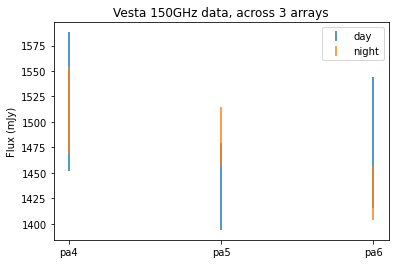

In [7]:
for i in range(1):
    desig, name, semimajor = get_desig(i)
    print(name)

    ast = minorplanet(name, semimajor)

    ast.make_all_stacks(weight_type = 'spt', verbose = False)#, plot = True, verbose = True, movie = True)

    names_night = ['pa4', 'pa5', 'pa6']
    names_day = ['pa4', 'pa5', 'pa6']

    values_night = []
    errs_night = []
    values_day = []
    errs_day = []

    for pa in names_night:
        values_night.append(ast.flux_dict['night'][pa]['150']['flux'])
        errs_night.append(ast.flux_dict['night'][pa]['150']['var'])

        values_day.append(ast.flux_dict['day'][pa]['150']['flux'])
        errs_day.append(ast.flux_dict['day'][pa]['150']['var'])

    plt.errorbar(names_day, values_day, yerr=errs_day, linestyle='none', zorder=0, label = 'day')
    plt.errorbar(names_night, values_night, yerr=errs_night, linestyle='none', zorder=2, label = 'night')

    plt.title('{} 150GHz data, across 3 arrays'.format(name))
    plt.ylabel('Flux (mJy)')
    plt.legend()
    plt.savefig('/home/r/rbond/jorlo/dev/minorplanets/plots/{}_150_pas.pdf'.format(name))
    plt.savefig('/home/r/rbond/jorlo/dev/minorplanets/plots/{}_150_pas.png'.format(name))
    plt.show()
    plt.close()

In [8]:
from scipy.optimize import leastsq

linear_residual = lambda A, x, y, yerr: (A-y)/yerr
for i in range(30):
    desig, name, semimajor = get_desig(i)
    
    names_night = ['pa4', 'pa5', 'pa6']
    values_night = []
    errs_night = []
    
    with open('/scratch/r/rbond/jorlo/actxminorplanets/sigurd/fluxes/{}_flux_dict.pk'.format(name), 'rb') as f:
        try:
            flux_dict = pk.load(f)
        except:
            continue
        
    for pa in names_night:
        values_night.append(flux_dict['night'][pa]['150']['flux'])
        errs_night.append(flux_dict['night'][pa]['150']['var'])

        
    pf, cov, info, mesg, success = leastsq(linear_residual, np.mean(values_night), args=([1,2,3], values_night, errs_night), full_output=1)
    
    print(name)
    print('Best fit flux', pf[0], '\n')
    for pa in names_night:
        print('Flux of {}'.format(pa), flux_dict['night'][pa]['150']['flux'])
        print('Sigma diff of {}'.format(pa), (flux_dict['night'][pa]['150']['flux']-pf[0])/flux_dict['night'][pa]['150']['var'])
        print('Percent diff of {}'.format(pa), 100*(flux_dict['night'][pa]['150']['flux']-pf[0])/flux_dict['night'][pa]['150']['flux'])
    print('\n')
    
    plt.errorbar(names_day, values_night, yerr=errs_night, linestyle='none', zorder=0, label = 'Night Data')
    plt.plot(names_day,np.ones(len(names_day))*pf, label = 'Best Fit')
    plt.title('{} 150GHz data, across 3 arrays'.format(name))
    plt.ylabel('Flux (mJy)')
    plt.legend()
    plt.savefig('/home/r/rbond/jorlo/dev/minorplanets/plots/{}_150_pas.pdf'.format(name))
    plt.savefig('/home/r/rbond/jorlo/dev/minorplanets/plots/{}_150_pas.png'.format(name))
    #plt.show()
    plt.close()

Vesta
Best fit flux 1466.015403134915 

Flux of pa4 1511.3431
Sigma diff of pa4 1.059959882368588
Percent diff of pa4 2.9991691049106457
Flux of pa5 1486.2559
Sigma diff of pa5 0.71966347359856
Percent diff of pa5 1.3618419811375215
Flux of pa6 1430.2483
Sigma diff of pa6 -1.342294460071432
Percent diff of pa6 -2.500762444113227


Ceres
Best fit flux 6211.78943562877 

Flux of pa4 6336.418
Sigma diff of pa4 1.4371172699376669
Percent diff of pa4 1.9668609889037356
Flux of pa5 6180.971
Sigma diff of pa5 -0.6385991797800457
Percent diff of pa5 -0.4985987358324543
Flux of pa6 3309.7961
Sigma diff of pa6 -3.1128297476192763
Percent diff of pa6 -87.6789133843806


Pallas
Best fit flux 2521.6205038673047 

Flux of pa4 2630.5745
Sigma diff of pa4 4.160678508174033
Percent diff of pa4 4.141831396918355
Flux of pa5 2474.7327
Sigma diff of pa5 -2.6071195291500526
Percent diff of pa5 -1.8946627446095086
Flux of pa6 2517.4617
Sigma diff of pa6 -0.24061729649035302
Percent diff of pa6 -0.1651994942

Pluto
Best fit flux 32129.026228949624 

Flux of pa4 22556.62
Sigma diff of pa4 -0.319419532143087
Percent diff of pa4 -42.43724216225513
Flux of pa5 19458.49
Sigma diff of pa5 -0.6324937455100728
Percent diff of pa5 -65.11571988350408
Flux of pa6 57107.137
Sigma diff of pa6 1.0270684138946813
Percent diff of pa6 43.73903495252513


Nausikaa
Best fit flux 150.566044007455 

Flux of pa4 44.514355
Sigma diff of pa4 -0.6618461010529407
Percent diff of pa4 -238.24155152315686
Flux of pa5 196.10536
Sigma diff of pa5 0.4704658544812925
Percent diff of pa5 23.22186271750614
Flux of pa6 135.91565
Sigma diff of pa6 -0.10341085859692678
Percent diff of pa6 -10.779034391220508


Eleonora
Best fit flux 151.82516443303047 

Flux of pa4 94.69214
Sigma diff of pa4 -1.651582425292615
Percent diff of pa4 -60.33555325973944
Flux of pa5 177.82947
Sigma diff of pa5 1.2045738393670613
Percent diff of pa5 14.623168851597558
Flux of pa6 141.45154
Sigma diff of pa6 -0.2890665671138895
Percent diff of pa6 -7.3

In [9]:
with open('/scratch/r/rbond/jorlo/actxminorplanets/sigurd/fluxes/Pallas_flux_dict.pk'.format(name), 'rb') as f:
        flux_dict = pk.load(f)

# Weighting Diagnostics

In [9]:
desig, name, semimajor = get_desig(0)
print(name)

ast = minorplanet(name, semimajor)
ast.make_all_stacks(weight_type = 'spt',  weight_debug = True)

Vesta


In [10]:
pa = 'pa6'
freq = '090'
name = name

with open('/home/r/rbond/jorlo/dev/minorplanets/pks/{}_debug_{}_{}_{}.pk'.format(name, 'night', pa, freq), 'rb') as f:
    debug_dict_night = pk.load(f)
with open('/home/r/rbond/jorlo/dev/minorplanets/pks/{}_debug_{}_{}_{}.pk'.format(name, 'day', pa, freq), 'rb') as f:
    debug_dict_day = pk.load(f)

In [11]:
iso_day = np.array(debug_dict_day['iso'])
hours_day = np.array(debug_dict_day['hour'])
sn_day = np.array(debug_dict_day['sn'])
weight_day = np.array(debug_dict_day['weights'])
alpha_day = np.array(debug_dict_day['alphas'])
r_sun_day = np.array(debug_dict_day['r_sun'])
r_earth_day = np.array(debug_dict_day['r_earth'])
fluxes_day = np.array(debug_dict_day['fluxes'])
sn_day = np.array(debug_dict_day['sn'])

iso_night = np.array(debug_dict_night['iso'])
hours_night = np.array(debug_dict_night['hour'])
sn_night = np.array(debug_dict_night['sn'])
weight_night = np.array(debug_dict_night['weights'])
alpha_night = np.array(debug_dict_night['alphas'])
r_sun_night = np.array(debug_dict_night['r_sun'])
r_earth_night = np.array(debug_dict_night['r_earth'])
fluxes_night = np.array(debug_dict_night['fluxes'])
sn_night = np.array(debug_dict_night['sn'])

var_day = fluxes_day/sn_day
var_night = fluxes_night/sn_night

In [12]:
def scaling_night(A, x):
    flag = np.where((iso_night == x))[0]
    return A*(r_sun_night[flag]**(-1/2) * r_earth_night[flag]**(-2) *10**(-0.004*alpha_night[flag]))

def scaling_day(A, x):
    flag = np.where((iso_day == x))[0]
    return A*(r_sun_day[flag]**(-1/2) * r_earth_day[flag]**(-2) *10**(-0.004*alpha_day[flag]))

linear_residual_night = lambda A, x, y, yerr: (scaling_night(A,x)-y)/yerr
linear_residual_day = lambda A, x, y, yerr: (scaling_day(A,x)-y)/yerr

from scipy.optimize import leastsq
from scipy.interpolate import interp1d

In [13]:
pf_night, cov_night, info, mesg, success = leastsq(linear_residual_night, 100, args=(iso_night, fluxes_night, var_night), full_output=1)
pf_day, cov_day, info, mesg, success = leastsq(linear_residual_day, 100, args=(iso_day, fluxes_day, var_day), full_output=1)

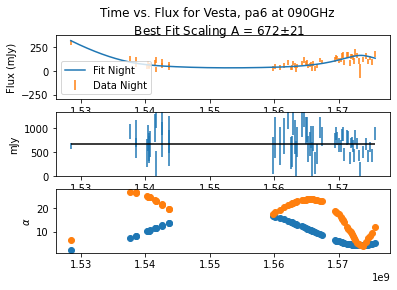

In [14]:
fig, ax = plt.subplots(3, 1)

plot_day = False
interp_flux_night = interp1d(iso_night, scaling_night(pf_night, iso_night), kind='cubic', fill_value='extrapolate')
interp_flux_day = interp1d(iso_day, scaling_day(pf_day, iso_day), kind='cubic', fill_value='extrapolate')

xs = np.linspace(min(iso_night), max(iso_night), 1000)

ax[0].plot(xs, interp_flux_night(xs), label = 'Fit Night')
ax[0].errorbar(iso_night, fluxes_night, yerr=var_night, linestyle = 'none', label = 'Data Night')

#ax[0].scatter(iso_night, scaling_night(pf_night, iso_night),  label = 'Model(data) Night')

if plot_day:
    plt.plot(xs, interp_flux_day(xs), label = 'Fit Day')
    plt.errorbar(iso_day, fluxes_day, yerr=var_day, linestyle = 'none', label = 'Data Day')


fig.suptitle('Time vs. Flux for {}, {} at {}GHz\n Best Fit Scaling A = {:.0f}$\pm${:.0f}'.format(
    name, pa, freq, pf_night[0], np.sqrt(cov_night[0,0])))
ax[0].set_xlabel('ISO')
ax[0].set_ylabel('Flux (mJy)')
ax[0].legend()
ax[0].set_ylim(-300, max(fluxes_night)*1.25)

ax[1].errorbar(iso_night, fluxes_night*weight_night, yerr=weight_night*var_night, linestyle = 'none', label = 'Data Night')
ax[1].set_ylim(0,ast.flux_dict['night'][pa][freq]['flux']*2)
ax[1].hlines(ast.flux_dict['night'][pa][freq]['flux'], min(iso_night), max(iso_night), color='black')
ax[1].set_xlabel('ISO\n Weighted Stack Flux = {:.0f}$\pm${:.0f}'.format(ast.flux_dict['night'][pa][freq]['flux'], ast.flux_dict['night'][pa][freq]['var']))
ax[1].set_ylabel('mJy')

ax[2].scatter(iso_night, weight_night)
ax[2].set_ylabel(r'Weight')

ax[2].scatter(iso_night, alpha_night)
ax[2].set_ylabel(r'$\alpha$')

plt.savefig('./plots/{}_flux_time_{}_{}.pdf'.format(name, pa,freq), dpi=600)
plt.savefig('./plots/{}_flux_time_{}_{}.png'.format(name, pa,freq), dpi=600)

plt.show()
plt.close()

In [32]:
plt.plot(xs, interp_flux_night(xs), label = 'Fit Night')
plt.errorbar(iso_night, fluxes_night, yerr=var_night, linestyle = 'none', label = 'Data Night')

In [21]:
np.where(fluxes_night>300)

In [23]:
fluxes_night[44]/var_night[44]

In [17]:
region_flags = np.where((iso_night>1.50e9) & (iso_night<1.54e9))[0]

In [18]:
iso_night_reg = iso_night[region_flags]
#hours_night_reg = hours_night[region_flags]
sn_night_reg = sn_night[region_flags]
weight_night_reg = weight_night[region_flags]
alpha_night_reg = alpha_night[region_flags]
r_sun_night_reg = r_sun_night[region_flags]
r_earth_night_reg = r_earth_night[region_flags]
fluxes_night_reg = fluxes_night[region_flags]
sn_night_reg = sn_night[region_flags]

var_night_reg = fluxes_night_reg/sn_night_reg

In [19]:
def scaling_night_reg(A, x):
    flag = np.where((iso_night_reg == x))[0]
    return A*(r_sun_night_reg[flag]**(-1/2) * r_earth_night_reg[flag]**(-2) *10**(-0.004*alpha_night_reg[flag]))

linear_residual_night_reg = lambda A, x, y, yerr: (scaling_night_reg(A,x)-y)/yerr

In [20]:
pf_night_reg, cov_night_reg, info, mesg, success = leastsq(linear_residual_night_reg, 100, 
                                                           args=(iso_night_reg, fluxes_night_reg, var_night_reg), full_output=1)


In [21]:
fig, ax = plt.subplots(3, 1)

xs = np.linspace(min(iso_night_reg), max(iso_night_reg), 1000)

ax[0].errorbar(iso_night_reg, fluxes_night_reg, yerr=var_night_reg, linestyle = 'none', label = 'Data Night')
#ax[0].scatter(iso_night_reg, scaling_night_reg(pf_night_reg, iso_night_reg), color='black', linewidths = 1,
#              marker = 'x', label = 'Model(data) Night')



fig.suptitle('Time vs. Flux for {}, {} at {}GHz\n Best Fit Scaling A = {:.0f}$\pm${:.0f}'.format(
    name, pa, freq, pf_night[0], np.sqrt(cov_night[0,0])))
ax[0].set_xlabel('ISO')
ax[0].set_ylabel('Flux (mJy)')
ax[0].legend()
ax[0].set_ylim(0, max(fluxes_night)*1.25)

ax[1].scatter(iso_night_reg, alpha_night_reg)
ax[1].set_ylabel(r'$\alpha$')

ax[2].scatter(iso_night_reg, weight_night_reg)
ax[2].set_ylabel(r'Weight')
#ax[1].errorbar(iso_night, fluxes_night*weight_night, yerr=weight_night*var_night, linestyle = 'none', label = 'Data Night')
#ax[1].set_ylim(0,ast.flux_dict['night'][pa][freq]['flux']*2)
#ax[1].hlines(ast.flux_dict['night'][pa][freq]['flux'], min(iso_night), max(iso_night), color='black')
#ax[1].set_xlabel('ISO\n Weighted Stack Flux = {:.0f}$\pm${:.0f}'.format(ast.flux_dict['night'][pa][freq]['flux'], ast.flux_dict['night'][pa][freq]['var']))
#ax[1].set_ylabel('mJy')
plt.savefig('./plots/sus_{}_flux_time_{}_{}.pdf'.format(name, pa,freq), dpi=600)
plt.savefig('./plots/sus_{}_flux_time_{}_{}.png'.format(name, pa,freq), dpi=600)

plt.show()
plt.close()

# pa4 vs pa5 Diff

In [120]:
desig, name, semimajor = get_desig(4)
print(name)
    
ast = minorplanet(name, semimajor)

In [121]:
pa_dict = ast.dif_pa4_pa5(weight_type='spt', verbose = False)

pa4_flux = np.array(pa_dict['pa4']['flux'])
pa4_time = np.array(pa_dict['pa4']['time'])
pa4_weight = np.array(pa_dict['pa4']['weight'])
pa4_kappa = np.array(pa_dict['pa4']['kappa'])
pa4_weighted_flux = np.array(pa_dict['pa4']['weighted_flux'])

pa5_flux = np.array(pa_dict['pa5']['flux'])
pa5_time = np.array(pa_dict['pa5']['time'])
pa5_kappa = np.array(pa_dict['pa5']['kappa'])
pa5_weight = np.array(pa_dict['pa5']['weight'])
pa5_weighted_flux = np.array(pa_dict['pa5']['weighted_flux'])


In [122]:
fig, ax = plt.subplots(3, 1)

ax[0].scatter(pa4_time, pa4_flux, label = 'pa4')
ax[0].scatter(pa5_time, pa5_flux, label = 'pa5')

ax[0].legend()
ax[0].set_ylabel('Flux (mJy)')

ax[1].scatter(pa4_time, pa4_weight, label = 'pa4')
ax[1].scatter(pa5_time, pa5_weight, label = 'pa5')

ax[1].legend()
ax[1].set_ylabel('Weight')

ax[2].scatter(pa4_time, pa4_kappa, label = 'pa4')
ax[2].scatter(pa5_time, pa5_kappa, label = 'pa5')

ax[2].legend()
ax[2].set_ylabel('Kappa')
ax[2].set_xlabel('ISO')


plt.show()
plt.close()

In [123]:
plt.scatter(pa4_time, pa4_flux, label = 'pa4')
plt.scatter(pa5_time, pa5_flux, label = 'pa5')

plt.legend()
plt.xlabel('ISO')
plt.ylabel('Flux (mJy)')

plt.title('PA4 vs PA5 flux\n PA4 = {:.0f}, PA5 = {:.0f}'.format(np.mean(pa4_flux), np.mean(pa5_flux)))

plt.savefig('./plots/pa4_vs_pa5_flux_{}.png'.format(name), dpi=600)

plt.show()
plt.close()

In [124]:
plt.scatter(pa4_time, pa4_weight, label = 'pa4')
plt.scatter(pa5_time, pa5_weight, label = 'pa5')

plt.title('PA4 vs PA5 Weight\n PA4 = {:.1f}, PA5 = {:.1f}'.format(np.mean(pa4_weight), np.mean(pa5_weight)))

plt.savefig('./plots/pa4_vs_pa5_weight_{}.png'.format(name), dpi=600)

plt.legend()
plt.xlabel('ISO')
plt.ylabel('Weight')
plt.show()
plt.close()

In [125]:
plt.scatter(pa4_time, pa4_kappa, label = 'pa4')
plt.scatter(pa5_time, pa5_kappa, label = 'pa5')

plt.title('PA4 vs PA5 Kappa\n PA4 = {:.5f}, PA5 = {:.5f}'.format(np.mean(pa4_kappa), np.mean(pa5_kappa)))

plt.savefig('./plots/pa4_vs_pa5_kappa_{}.png'.format(name), dpi=600)


plt.legend()
plt.xlabel('ISO')
plt.ylabel('Kappa')
plt.show()
plt.close()

In [126]:
plt.scatter(pa4_time, pa4_weighted_flux, label = 'pa4')
plt.scatter(pa5_time, pa5_weighted_flux, label = 'pa5')

plt.title('PA4 vs PA5 Weighted Flux \n PA4 = {:.5f}, PA5 = {:.5f}'.format(np.mean(pa4_weighted_flux), np.mean(pa5_weighted_flux)))

plt.savefig('./plots/pa4_vs_pa5_weighted_flux_{}.png'.format(name), dpi=300)


plt.legend()
plt.xlabel('ISO')
plt.ylabel('Weighted Flux')
plt.show()
plt.close()

In [127]:
print(np.mean(pa4_flux), np.std(pa4_flux))
print(np.mean(pa5_flux), np.std(pa5_flux))

In [128]:
time_intersect_pa4 = [i for i, time in enumerate(pa4_time) if time in pa5_time]
time_intersect = np.intersect1d(pa4_time, pa5_time)

flags_pa4 = [i for i, time in enumerate(pa4_time) if time in time_intersect]
flags_pa5 = [i for i, time in enumerate(pa5_time) if time in time_intersect]

In [134]:
pa4_flux_int = pa4_flux[flags_pa4]
pa4_time_int = pa4_time[flags_pa4]
pa4_kappa_int = pa4_kappa[flags_pa4]

pa5_flux_int = pa5_flux[flags_pa5]
pa5_time_int = pa5_time[flags_pa5]
pa5_kappa_int = pa5_kappa[flags_pa5]

pa4_weighted_flux_int = pa4_weighted_flux[flags_pa4]
pa4_time_int = pa4_time[flags_pa4]
pa5_weighted_flux_int = pa5_weighted_flux[flags_pa5]
pa5_time_int = pa5_time[flags_pa5]

pa4_var = 1/np.sqrt(pa4_kappa_int)
pa5_var = 1/np.sqrt(pa5_kappa_int)

In [135]:
sn_pa4 = pa4_flux_int*np.sqrt(pa4_kappa_int)
sn_pa5 = pa5_flux_int*np.sqrt(pa5_kappa_int)

In [136]:
sn_flags = np.where((np.array(sn_pa4)>2) & (np.array(sn_pa5) >2))[0]

In [137]:
plt.scatter(pa4_time_int, pa4_flux_int, color = 'blue', label = 'pa4')
plt.scatter(pa5_time_int, pa5_flux_int, color = 'orange', label = 'pa5')
#plt.hlines(np.mean(pa4_flux_int), min(pa4_time_int), max(pa4_time_int), color='blue', label= 'pa4 mean')
#plt.hlines(np.mean(pa5_flux_int), min(pa5_time_int), max(pa5_time_int), color='orange', label= 'pa5 mean')

plt.legend()
#plt.title('pa4 vs pa5 for {}\n pa4 = {:.0f} , pa5 = {:.0f} '.format(name,
#                                    np.mean(pa4_flux_int), np.mean(pa5_flux_int)))

plt.title('pa4 vs pa5 for {}'.format(name))

plt.xlabel('Time (ISO)')
plt.ylabel('flux (mJy)')
plt.savefig('./plots/pa4_pa5_{}.pdf'.format(name), dpi = 600)
plt.savefig('./plots/pa4_pa5_{}.png'.format(name), dpi = 600)

plt.show()
plt.close()

In [103]:
pa4_time_int  = pa4_time_int[sn_flags]
pa4_flux_int  = pa4_flux_int[sn_flags]

pa5_time_int  = pa5_time_int[sn_flags]
pa5_flux_int  = pa5_flux_int[sn_flags]

pa4_var = pa4_var[sn_flags]
pa5_var = pa5_var[sn_flags]

In [138]:
pa4_frac_var = np.sqrt(pa4_var)/pa4_flux_int
pa5_frac_var = np.sqrt(pa5_var)/pa5_flux_int


frac_var = np.sqrt(pa4_frac_var**2 + pa5_frac_var**2)

In [139]:
frac_var

In [142]:
sorted_pa4_flux_int = np.array([flux for _, flux in sorted(zip(pa4_time_int, pa4_flux_int))])
sorted_pa5_flux_int = np.array([flux for _, flux in sorted(zip(pa5_time_int, pa5_flux_int))])

frac_var = np.array([flux for _, flux in sorted(zip(pa4_time_int, frac_var))])

frac_flux = (sorted_pa4_flux_int-sorted_pa5_flux_int)/sorted_pa4_flux_int
ratio_flux = sorted_pa5_flux_int/sorted_pa4_flux_int

#plt.scatter(np.sort(pa4_time_int), frac_flux*100)
plt.errorbar(np.sort(pa4_time_int), ratio_flux, yerr = ratio_flux*frac_var, linestyle = 'none')

#plt.yscale('symlog')
#plt.hlines(np.mean(frac_flux), min(pa4_time_int), max(pa4_time_int), color='black', label= 'mean')

plt.title(r'Percent Dif, $\frac{pa5}{pa4}$')
plt.xlabel('Unix Time')
plt.ylabel('Ratio PA5/PA4')
plt.ylim(0.25,4)
#plt.yscale('symlog')

plt.savefig('./plots/diff_pa4_pa5_{}.pdf'.format(name), dpi = 600)
plt.savefig('./plots/diff_pa4_pa5_{}.png'.format(name), dpi = 600)

In [112]:
sorted_pa4_flux_int

In [115]:
1/np.sqrt(pa4_kappa_int[sn_flags])

In [113]:
sorted_pa5_flux_int

In [143]:
ratios = []
var = []

pa4s = []
pa5s = []

pa4var = []
pa5var = []

for i in range(20):
    desig, name, semimajor = get_desig(i)
    print(name)

    ast = minorplanet(name, semimajor)
    
    ast.make_stack('pa4', freq='150', weight_type = 'spt', time='night')
    ast.make_stack('pa5', freq='150', weight_type = 'spt', time='night')
    
    pa4_flux = ast.flux_dict['night']['pa4']['150']['flux']
    pa4_var = ast.flux_dict['night']['pa4']['150']['var']
    
    pa5_flux = ast.flux_dict['night']['pa5']['150']['flux']
    pa5_var = ast.flux_dict['night']['pa5']['150']['var']


    if pa4_var/pa4_flux < 0.1 and pa5_var/pa5_flux < 0.1:
        ratios.append(pa4_flux/pa5_flux)
        var.append(np.sqrt((pa4_var/pa4_flux)**2 + (pa5_var/pa5_flux)**2))
        
        pa4s.append(pa4_flux)
        pa5s.append(pa5_flux)
        
        pa4var.append(pa4_var)
        pa5var.append(pa5_var)

    


In [144]:
pa4s

In [145]:
pa5s

In [155]:
diffs = []
dif_vars = []
ratios = []
ratio_vars = []
for i in range(len(pa4s)):
    diffs.append((pa4s[i]-pa5s[i])/min(pa4s[i], pa5s[i]))
    dif_vars.append(np.sqrt(pa4var[i]**2+pa5var[i]**2))
    ratios.append(pa4s[i]/pa5s[i])
    
    rel_var = np.sqrt((pa4var[i]/pa4s[i])**2+(pa5var[i]/pa5s[i])**2)
    ratio_vars.append(rel_var*ratios[i])

In [156]:
np.mean(np.abs(diffs))

In [157]:
ratios

In [159]:
np.mean(ratios)

In [163]:
np.sqrt(np.sum(np.array(ratio_vars)**2))/np.sqrt(len(ratio_vars))

In [164]:
ratio_vars

In [154]:
np.sqrt((pa4var[0]/pa4s[0])**2+(pa5var[0]/pa5s[0])**2)

In [18]:
varsum = 0

for i in range(len(diffs)):
    varsum += (dif_vars[i]/(pa4s[i] - pa5s[i])*diffs[i])**2

print(np.sqrt(varsum)/np.sqrt(len(diffs)))

# Alpha issues

In [376]:
with open('/home/r/rbond/jorlo/dev/minorplanets/pks/alpha_pallas.pk', 'rb') as f:
    alpha_dict = pk.load(f)

times = alpha_dict[0]
alphas = alpha_dict[1]

from asteroid_utils_pixell import compute_alpha
import ephem
from astroquery.jplhorizons import Horizons

sun = ephem.Sun()

In [445]:
alphas_calc = np.zeros(len(alphas))

for i, time in enumerate(times):
    print(i, end = '\r')
    time_eph = Time(time, format='mjd')
    time = utils.mjd2djd(time)

    sun.compute(time)
    
    eph_table = Horizons(id = 'Pallas', location='W99', epochs = time_eph)
    ephs = eph_table.ephemerides()
    
    ra_sun = sun.ra#*np.pi/180
    dec_sun = sun.dec#*np.pi/180
    sun_dist = sun.earth_distance
    
    earth_distance = ephs['delta'][0]
    ra_ast = ephs['RA'][0]
    dec_ast = ephs['DEC'][0]
    #print(dec_ast*180/np.pi)
    alpha = compute_alpha(ra_sun, dec_sun, sun_dist, ra_ast*utils.degree, dec_ast*utils.degree, earth_distance)
    
    alpha *= 180/np.pi
    
    #print(alpha)
    alphas_calc[i] = alpha
    #print('\n')
    

In [441]:
plt.plot(times, alphas, label = 'Ricco')
plt.plot(times, alphas_calc, label = 'Jack')

plt.legend()

In [446]:
(alphas-alphas_calc)/alphas

In [379]:
import numpy as np, ephem
from pixell import utils

def get_ephem(objname, ctime):
 
  djd = utils.ctime2djd(ctime)
  res = np.zeros((3,)+djd.shape)
  obj = getattr(ephem, objname)()
  for I in utils.nditer(djd.shape):
    obj.compute(djd[I])
    res[0,I] = obj.a_ra
    res[1,I] = obj.a_dec
    res[2,I] = obj.earth_distance
  return res

#d_ast   = np.load("/gpfs/fs0/project/r/rbond/sigurdkn/actpol/ephemerides/objects/Ceres.npy").view(np.recarray)
# Earth-to-asteroid vector
#v_ea    = utils.ang2rect([d_ast.ra*utils.degree, d_ast.dec*utils.degree])*d_ast.r
# Earth-to-sun vector
#pos_sun = get_ephem("Sun", d_ast.ctime)
#v_es    = utils.ang2rect([pos_sun[0], pos_sun[1]])*pos_sun[2]
# Sun angle is angle between ast→sun vector and ast→earth vector
#sunang  = utils.vec_angdist(-v_ea, -v_ea+v_es)

In [380]:
r_ast = np.zeros(len(times))
ra_ast = np.zeros(len(times))
dec_ast = np.zeros(len(times))

for i, time in enumerate(times):
    time_temp = Time(time, format='mjd')

    eph_table = Horizons(id = 'Pallas', location='W99', epochs =time_temp)
    ephs = eph_table.ephemerides()
    
    r_ast[i] = ephs['delta']
    ra_ast[i] = ephs['RA']
    dec_ast[i] = ephs['DEC']
    

In [381]:
v_ea = utils.ang2rect([ra_ast*utils.degree, dec_ast*utils.degree])*r_ast

times_ctime = utils.mjd2ctime(times)

pos_sun = get_ephem("Sun", times_ctime)
v_es    = utils.ang2rect([pos_sun[0], pos_sun[1]])*pos_sun[2]

In [382]:
sunang  = utils.vec_angdist(-v_ea, -v_ea+v_es)*180/np.pi

In [383]:
plt.plot(times, sunang)
plt.plot(times, alphas)

In [413]:
r_ast = np.zeros(len(iso_night))
ra_ast = np.zeros(len(iso_night))
dec_ast = np.zeros(len(iso_night))

for i, time in enumerate(iso_night):
    time_temp = Time(time, format='unix')

    eph_table = Horizons(id = 'Vesta', location='W99', epochs =time_temp.mjd)
    ephs = eph_table.ephemerides()
    
    r_ast[i] = ephs['delta']
    ra_ast[i] = ephs['RA']
    dec_ast[i] = ephs['DEC']
    
    print(time_temp)
    print(ephs['RA'][0])
    print(ephs['DEC'][0])
    print(ephs['delta'][0], '\n')

In [391]:
v_ea = utils.ang2rect([ra_ast*utils.degree, dec_ast*utils.degree])*r_ast

pos_sun = get_ephem("Sun", iso_night)
v_es    = utils.ang2rect([pos_sun[0], pos_sun[1]])*pos_sun[2]

sunang  = utils.vec_angdist(-v_ea, -v_ea+v_es)*180/np.pi

In [392]:
v_ea.shape

In [455]:
plt.scatter(iso_night, sunang, label = 'Sigurd')
plt.scatter(iso_night, alpha_night, label='Jack')
plt.scatter(iso_night, alpha_true, label = 'True')
plt.legend()

In [454]:
(alpha_true-sunang)/alpha_true

In [345]:
times = utils.ctime2mjd(iso_night)

In [346]:
times

In [414]:
alpha_true = np.zeros(len(iso_night))
alpha_calc = np.zeros(len(iso_night))
for i, time in enumerate(iso_night):
    print(i/len(iso_night), end = '\r')
    time_temp = Time(time, format='unix')
    eph_table = Horizons(id = 'Vesta', location='W99', epochs = time_temp.mjd)
    ephs = eph_table.ephemerides()
    
    alpha_true[i] = ephs['alpha']
    sun_time = utils.ctime2djd(time)
    #print(sun_time)
    sun.compute(sun_time)
        
    #print(time_temp)
    #print(ephs['RA'][0])
    #print(ephs['DEC'][0])
    #print(ephs['delta'][0], '\n')
    #print(sun.ra)
    #print(sun.dec)
    #print(sun.earth_distance, '\n')
    
    alpha = compute_alpha(sun.ra, sun.dec, sun.earth_distance, ephs['RA'][0]*np.pi/180, ephs['DEC'][0]*np.pi/180, ephs['delta'][0])
    alpha *= 180/np.pi
    
    alpha_calc[i] = alpha

In [433]:
(alpha_night-alpha_true)/alpha_night

In [432]:
alpha_true

In [350]:
iso_night

In [452]:
plt.scatter(iso_night, alpha_true, label = 'True')
plt.scatter(iso_night, alpha_night, label = 'From code')
#plt.scatter(iso_night, alpha_calc, label = 'Calc')

plt.legend()

NameError: name 'requests' is not defined

# Planet verification

In [2]:
name = 'Uranus'
semimajor = 18.2861

ast = minorplanet(name, semimajor,path = '/scratch/r/rbond/jorlo/actxminorplanets/sigurd/planets/')

In map:  Uranus_depth1_1602464607_pa4_f150_kappa.fits
2020-10-12 05:37:46
Weight =  355.03996590286727
Rho 	 Kappa 	 Flux 	 SN	 Scaled Flux

2.2593145 	 0.00014741361 	 15326.363 	 186.08351 	 5441471.496789956
Stack weight:  355.03996590286727
D_earth:  18.842504236509203
D_sun:  19.782687290246567
Kappa:  3.4197277e-05
S/n:  186.08353
Median S/n:  1.77487
Max flux:  5441471.5


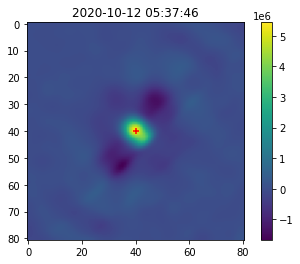

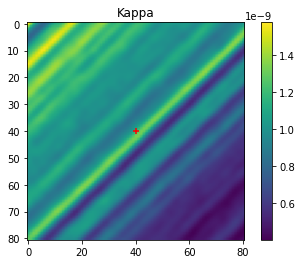

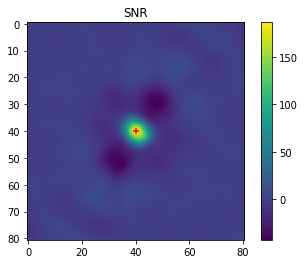

In map:  Uranus_depth1_1604195860_pa4_f150_kappa.fits
2020-11-01 06:12:48
Weight =  352.97877038882393
Rho 	 Kappa 	 Flux 	 SN	 Scaled Flux

4.885362 	 0.00026044238 	 18757.94 	 302.71988 	 6621154.403192071
Stack weight:  352.97877038882393
D_earth:  18.787729250466217
D_sun:  19.78009518233786
Kappa:  4.5720106e-05
S/n:  302.7199
Median S/n:  2.5382397
Max flux:  6621154.5


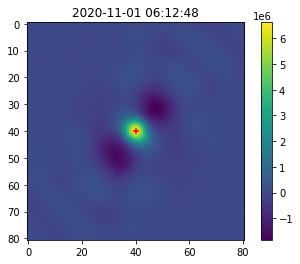

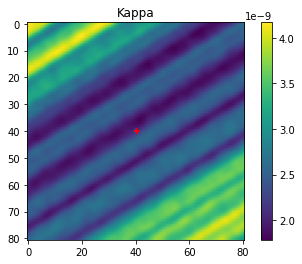

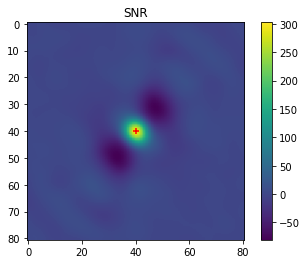

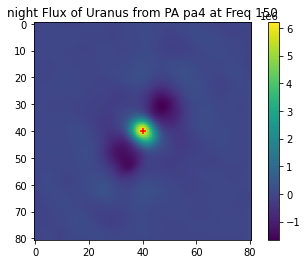

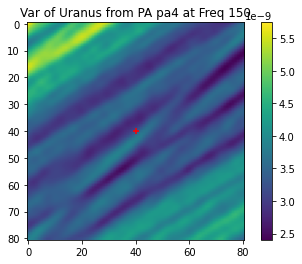

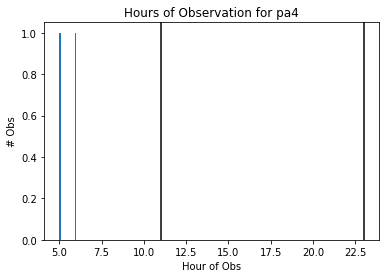

In map:  Uranus_depth1_1602464607_pa4_f150_kappa.fits
In map:  Uranus_depth1_1604195860_pa4_f150_kappa.fits
day pa4 150
In map:  Uranus_depth1_1604195860_pa4_f220_kappa.fits
2020-11-01 06:12:48
Weight =  352.97877038882393
Rho 	 Kappa 	 Flux 	 SN	 Scaled Flux

2.6031632 	 8.4688254e-05 	 30738.186 	 282.87192 	 10849926.938319458
Stack weight:  352.97877038882393
D_earth:  18.787729250466217
D_sun:  19.78009518233786
Kappa:  2.6071319e-05
S/n:  282.87192
Median S/n:  1.589334
Max flux:  10883997.0


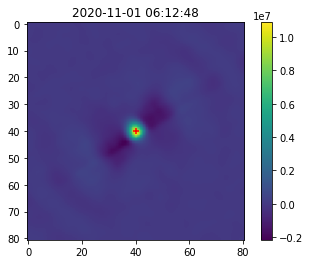

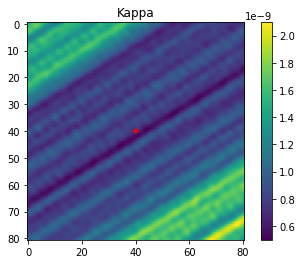

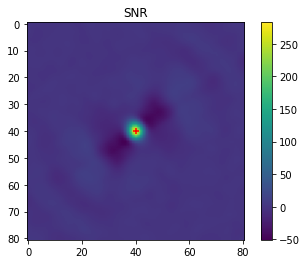

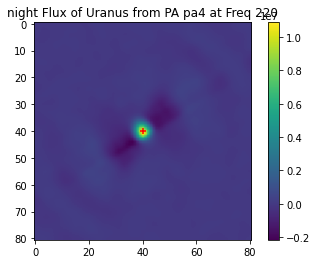

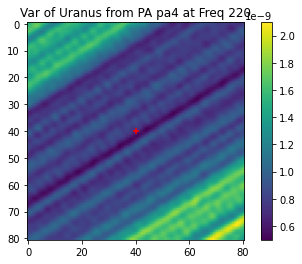

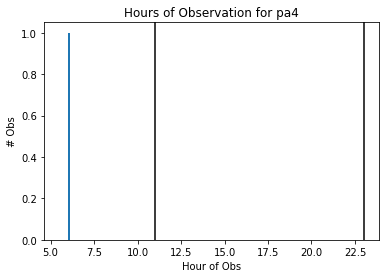

In map:  Uranus_depth1_1604195860_pa4_f220_kappa.fits
day pa4 220
In map:  Uranus_depth1_1604195860_pa5_f090_kappa.fits
2020-11-01 06:12:48
Weight =  352.97877038882393
Rho 	 Kappa 	 Flux 	 SN	 Scaled Flux

19.73074 	 0.0020519344 	 9615.678 	 435.57367 	 3394130.10313488
Stack weight:  352.97877038882393
D_earth:  18.787729250466217
D_sun:  19.78009518233786
Kappa:  0.00012833146
S/n:  435.5737
Median S/n:  6.112532
Max flux:  3394130.0


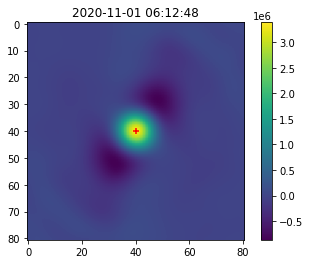

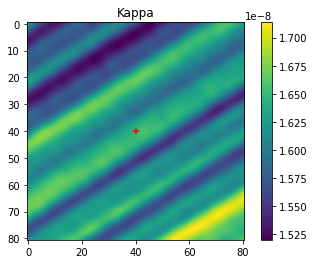

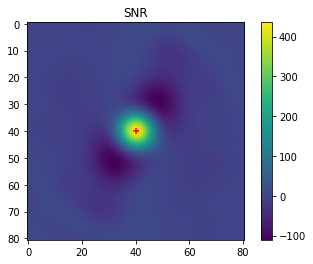

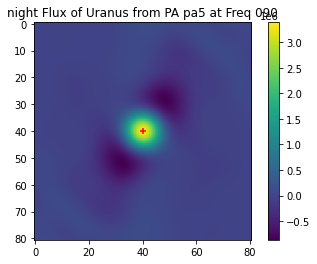

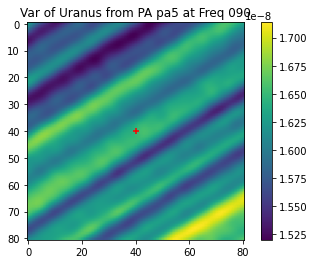

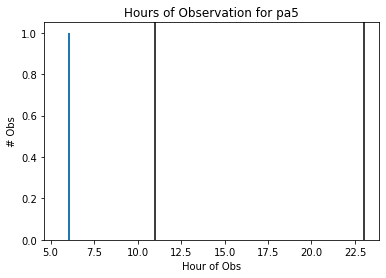

In map:  Uranus_depth1_1604195860_pa5_f090_kappa.fits
day pa5 090
In map:  Uranus_depth1_1602464607_pa5_f150_kappa.fits
2020-10-12 05:37:46
Weight =  355.03996590286727
Rho 	 Kappa 	 Flux 	 SN	 Scaled Flux

6.135549 	 0.00034318306 	 17878.357 	 331.20016 	 6347531.409461774
Stack weight:  355.03996590286727
D_earth:  18.842504236509203
D_sun:  19.782687290246567
Kappa:  5.217779e-05
S/n:  331.2001
Median S/n:  2.8429193
Max flux:  6347530.5


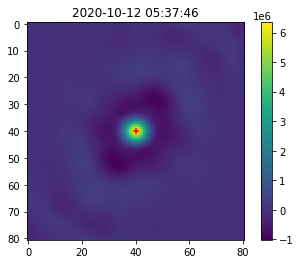

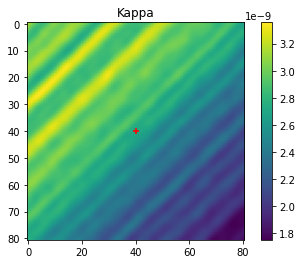

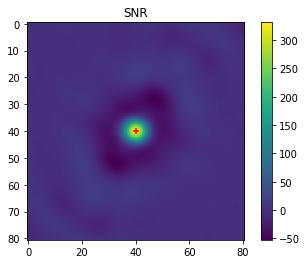

In map:  Uranus_depth1_1604195860_pa5_f150_kappa.fits
2020-11-01 06:12:48
Weight =  352.97877038882393
Rho 	 Kappa 	 Flux 	 SN	 Scaled Flux

24.53029 	 0.0013199971 	 18583.594 	 675.17474 	 6559614.071280434
Stack weight:  352.97877038882393
D_earth:  18.787729250466217
D_sun:  19.78009518233786
Kappa:  0.000102929036
S/n:  675.1748
Median S/n:  5.5802684
Max flux:  6559614.0


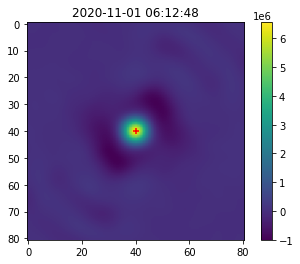

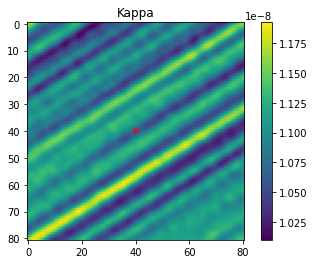

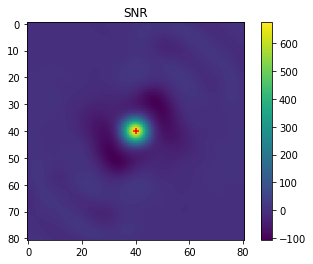

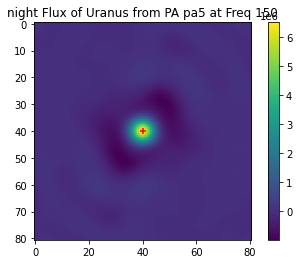

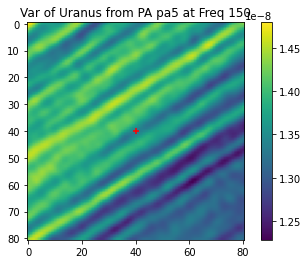

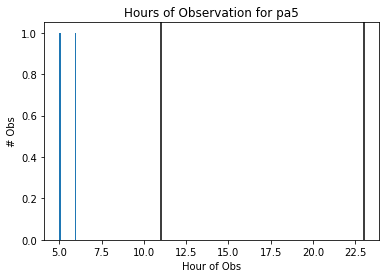

In map:  Uranus_depth1_1602464607_pa5_f150_kappa.fits
In map:  Uranus_depth1_1604195860_pa5_f150_kappa.fits
day pa5 150
night pa6 090
day pa6 090
night pa6 150
day pa6 150


In [3]:
ast.make_all_stacks(weight_type = 'earth_only', plot = True, verbose = True, movie = True)

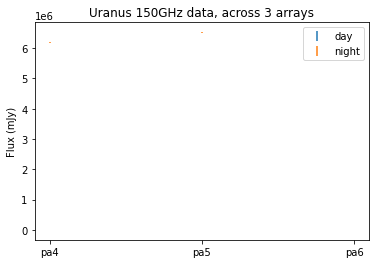

In [5]:
names_night = ['pa4', 'pa5', 'pa6']
names_day = ['pa4', 'pa5', 'pa6']

values_night = []
errs_night = []
values_day = []
errs_day = []

for pa in names_night:
    values_night.append(ast.flux_dict['night'][pa]['150']['flux'])
    errs_night.append(ast.flux_dict['night'][pa]['150']['var'])

    values_day.append(ast.flux_dict['day'][pa]['150']['flux'])
    errs_day.append(ast.flux_dict['day'][pa]['150']['var'])

plt.errorbar(names_day, values_day, yerr=errs_day, linestyle='none', zorder=0, label = 'day')
plt.errorbar(names_night, values_night, yerr=errs_night, linestyle='none', zorder=2, label = 'night')

plt.title('{} 150GHz data, across 3 arrays'.format(name))
plt.ylabel('Flux (mJy)')
plt.legend()
plt.savefig('/home/r/rbond/jorlo/dev/minorplanets/plots/{}_150_pas.pdf'.format(name))
plt.savefig('/home/r/rbond/jorlo/dev/minorplanets/plots/{}_150_pas.png'.format(name))
plt.show()
plt.close()

In [6]:
ast.flux_dict

{'day': {'pa4': {'150': {'flux': 0, 'var': 0}, '220': {'flux': 0, 'var': 0}},
  'pa5': {'090': {'flux': 0, 'var': 0}, '150': {'flux': 0, 'var': 0}},
  'pa6': {'090': {'flux': 0, 'var': 0}, '150': {'flux': 0, 'var': 0}}},
 'night': {'pa4': {'150': {'flux': array(6197940.5, dtype=float32),
    'var': 16797.49520258222},
   '220': {'flux': array(10849927., dtype=float32),
    'var': 31883.505883553793}},
  'pa5': {'090': {'flux': array(3394130., dtype=float32),
    'var': 7878.616642878918},
   '150': {'flux': array(6516255.5, dtype=float32), 'var': 8575.558204642304}},
  'pa6': {'090': {'flux': 0, 'var': 0}, '150': {'flux': 0, 'var': 0}}}}

In [7]:
print('PA4, 150: {:.0f} +\- {:.0f} Jy'.format(ast.flux_dict['night']['pa4']['150']['flux']/1e3, ast.flux_dict['night']['pa4']['150']['var']/1e3))
print('PA5, 150: {:.0f} +\- {:.0f} Jy'.format(ast.flux_dict['night']['pa5']['150']['flux']/1e3, ast.flux_dict['night']['pa5']['150']['var']/1e3))
print('PA4, 220: {:.0f} +\- {:.0f} Jy'.format(ast.flux_dict['night']['pa4']['220']['flux']/1e3, ast.flux_dict['night']['pa4']['220']['var']/1e3))
print('PA5, 090: {:.0f} +\- {:.0f} Jy'.format(ast.flux_dict['night']['pa5']['090']['flux']/1e3, ast.flux_dict['night']['pa5']['090']['var']/1e3))

PA4, 150: 6198 +\- 17 Jy
PA5, 150: 6516 +\- 9 Jy
PA4, 220: 10850 +\- 32 Jy
PA5, 090: 3394 +\- 8 Jy


In [44]:
from astropy import units as u
from astropy.cosmology import Planck15

my_beam = (np.pi*(1*u.arcsec)**2/(4*np.log(2))).to(u.sr)

freq = 143 * u.GHz
equiv_220 = u.thermodynamic_temperature(freq, Planck15.Tcmb0)
(581571.841 * u.mK).to(u.MJy / u.sr, equivalencies=equiv)*my_beam  


<Quantity 5.884687e-06 MJy>

In [40]:
pixel_size_220 = 0.008333*60
x_220 = 220/56.8
conversion_220 = 270.33*10**6*1*10**-6/2.73*x**4*np.exp(x_220)/(np.exp(x_220)-1)**2*(np.pi*(pixel_size_220)/(180*60))**2

pixel_size_150 = pixel_size_220*150/220
x_150 = 150/56.8
conversion_150 = 270.33*10**6*1*10**-6/2.73*x**4*np.exp(x_150)/(np.exp(x_150)-1)**2*(np.pi*(pixel_size_150)/(180*60))**2

pixel_size_090 = pixel_size_220*90/220
x_090 = 90/56.8
conversion_090 = 270.33*10**6*1*10**-6/2.73*x**4*np.exp(x_090)/(np.exp(x_090)-1)**2*(np.pi*(pixel_size_090)/(180*60))**2

In [36]:
#Uranus_depth1_1602464607_pa4_f150_kappa.fits vs pa4_f220_s20
tod_flux = conversion_220 * 640206.418*18.787729250466217**2 *np.sqrt(19.78009518233786)
print("TOD: ", round(tod_flux), '+\-', 
      round(tod_flux/283),
      "Depth-1: ", 10849, '+/-', 32)

TOD:  10273 +\- 36 Depth-1:  10849 +/- 32


In [41]:
# Uranus_depth1_1602464607_pa4_f150_kappa.fits vs pa4_f150_s20
tod_flux = conversion_150 * 207037.358*18.787729250466217**2 *np.sqrt(19.78009518233786)


print("TOD: ", round(tod_flux), '+\-', 
      round(tod_flux/166),
      "Depth-1: ", 5441, '+/-', round(5441/186))

TOD:  5888 +\- 35 Depth-1:  5441 +/- 29


In [42]:
# Uranus_depth1_1604195860_pa5_f090_kappa.fits vs pa4_f150_s20
tod_flux = conversion_090 * 90163.666*18.787729250466217**2 *np.sqrt(19.78009518233786)


print("TOD: ", round(tod_flux), '+\-', 
      round(tod_flux/80),
      "Depth-1: ", 3394, '+/-', round(3394/186))


TOD:  3623 +\- 45 Depth-1:  3394 +/- 18


# Dark Comets

In [53]:
name = '2016_RH120'
semimajor = 1

ast = minorplanet(name, semimajor, path = '/scratch/r/rbond/jorlo/actxminorplanets/sigurd/planets/')

In [54]:
ast.make_all_stacks(weight_type = 'spt')#, plot = True, verbose = True, weight_debug = True)

In [56]:
pas =['pa4', 'pa5', 'pa6']

for pa in pas:
    for freq in ast.flux_dict['night'][pa].keys():
        try:
            print("SN {}, {}GHz, {}".format(pa, freq, 
                                            ast.flux_dict['night'][pa][freq]['flux']/ast.flux_dict['night'][pa][freq]['var']))
            
        except ZeroDivisionError:
            continue

In [58]:
ast.flux_dict['day']

# Single Depth1 Stamp

In [6]:
name = 'Vesta'

path = '/scratch/r/rbond/jorlo/actxminorplanets/sigurd/asteroids/'

pa = 'pa5'
freq = '150'

In map:  Vesta_depth1_1604665183_pa5_f150_kappa.fits
48


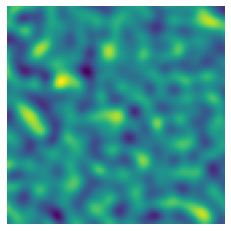

In [36]:
for i, dirname in enumerate(os.listdir(path=path+'/'+name+'/')):
    if dirname.find('kappa.fits') == -1: continue #Just look at the kappa maps
    if dirname.find(pa) == -1: continue
    if dirname.find('f'+str(freq)) == -1: continue #Check each file to see if it's the specified freq
    print('In map: ', dirname)
    
    rhofile    = utils.replace(dirname, "kappa.fits", "rho.fits")
    infofile = utils.replace(dirname, "kappa.fits", "info.hdf")


    kappa = enmap.read_map(path+'/'+name+'/' + dirname)
    rho = enmap.read_map(path+'/'+name+'/' + rhofile)
    info = bunch.read(path+'/'+name+'/' +infofile)

    flux = rho[0,:,:]/kappa[0,:,:]
    print(i)
    plt.imshow(flux)
    plt.axis('off')
    #plt.colorbar()
    plt.savefig('./plots/example_stamp.png', dpi=300)
    plt.savefig('./plots/example_stamp.pdf', dpi=300)

    plt.show()
    plt.close()
    break
    #fname = '{}_{}_{}_{}'.format(name, pa, freq, i)
    #enmap.write_map('./fits/{}.fits'.format(fname), flux)

In [19]:
rmap = enmap.read_map('/home/r/rbond/sigurdkn/project/actpol/maps/depth1/release/15999/depth1_1599991902_pa5_f150_rho.fits')
kmap = enmap.read_map('/home/r/rbond/sigurdkn/project/actpol/maps/depth1/release/15999/depth1_1599991902_pa5_f150_kappa.fits')

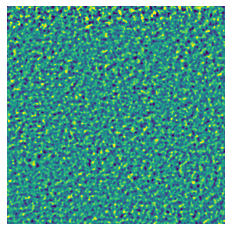

In [31]:


plt.imshow(rmap[0,100:400,1000:1300]/kmap[0,100:400,1000:1300], vmin=-100, vmax=100)
plt.axis('off')
plt.savefig('./plots/example_depth1.png', dpi=300)
plt.savefig('./plots/example_depth1.pdf', dpi=300)


In [132]:
orbits = OrbitInterpolator(table)

In [133]:
t_start = Time('2013-01-01T00:00:00', format='isot', scale='utc')
t_start = t_start.mjd

t_en = Time('2020-01-01T00:00:00', format='isot', scale='utc')
t_en = t_en.mjd
mjds = np.linspace(t_start, t_en, 1000)

ras, decs, delts = orbits.get_radec_dist(table['targetname'][0], mjds)

plt.plot(ras, decs)
plt.show()

In [134]:
flux_stack, fstack, kstack, flux_scale = tnoStacker(orbits,table['targetname'][0])


In [106]:
plt.imshow(flux_stack)
plt.savefig('/scratch/r/rbond/jorlo/actxminorplanets/asteroids/plots/{}_stamp.pdf'.format(str(table['targetname'][0]).replace(' ', '_').replace('(','').replace(')','')))
plt.show()

aster_dict = {'flux_stack':flux_stack, 'fstack':fstack, 'kstack':kstack, 'flux_scale':flux_scale}
with open('/scratch/r/rbond/jorlo/actxminorplanets/asteroids/pks/{}_stamp.pk'.format(str(table['targetname'][0]).replace(' ', '_').replace('(','').replace(')','')), 'wb') as f:
    pk.dump(aster_dict, f)

In [107]:
with open('/scratch/r/rbond/jorlo/actxminorplanets/asteroids/pks/{}_stamp.pk'.format(str(table['targetname'][0]).replace(' ', '_').replace('(','').replace(')','')), 'rb') as f:
    aster_dict = pk.load(f)
    kstack = aster_dict['kstack']
    fstack = aster_dict['fstack']
    
    flux_stack = fstack/kstack    
    plt.imshow(flux_stack)
    plt.show()

In [38]:
path = '/home/r/rbond/sigurdkn/scratch/actpol/planet9/20200801/maps/combined/'


table = QueryHorizons(time_start='2010-01-01T00:00:00', time_end='2020-01-01T00:00:00', observer_location='W99', step = '1d').queryObjects([502])

orbits =  OrbitInterpolator(table)

for  dirname in os.listdir(path=path):
    try:
        with h5py.File(path + dirname +"/info.hdf", "r") as hfile:
            #Find the (rough) mjd center of the map
            mjd_cent = hfile["mjd"][()]
            
        print(hfile.header())

    except:
        print('no info file in ', dirname)
        continue
    ra, dec, delta = orbits.get_radec_dist(table['targetname'][0], mjd_cent)
    print(ra, dec, delta)

In [72]:
table['targetname'][0]

In [ ]:
path = '/global/cscratch1/sd/jorlo/three_day_maps/'

table = QueryHorizons(time_start='2010-01-01T00:00:00', time_end='2020-01-01T00:00:00', observer_location='W99', step = '1d').queryObjects(['Ceres'])

orbits =  OrbitInterpolator(table)

for  dirname in os.listdir(path=path):
    print(dirname)
    try:
        with h5py.File(path + dirname +"/info.hdf", "r") as hfile:
            #Find the (rough) mjd center of the map
            mjd_cent = hfile["mjd"][()]

    except:
        print('no info file in ', dirname)
        continue
    print(mjd_cent)
    ra, dec, delta = orbits.get_radec_dist(table['targetname'][0], mjd_cent)
    print('ra, dec: ', ra, dec)
    
    hdu = fits.open(path + dirname + '/kmap.fits')
    w = wcs.WCS(hdu[0].header)
    
    c = SkyCoord(ra, dec, unit="deg")
    x, y = w.world_to_pixel(c)
    print(x,y)
    kmap = enmap.read_map(path + dirname + '/kmap.fits')
    try:
        fmap = enmap.read_map(path + dirname + '/frhs.fits')
    except: continue
    plt.imshow(kmap)
    plt.plot(x,y, color='red', marker='+')
    #plt.show()
    plt.close()

    plt.imshow(fmap[int(y-50):int(y+50),int(x-50):int(x+50)])
    #plt.show()
    plt.close()

In [52]:
path = '/home/r/rbond/sigurdkn/scratch/actpol/planet9/20200801/maps/combined/'


with h5py.File(path + 's18_cmb_1536796800' +"/info.hdf", "r") as hfile:
    #Find the (rough) mjd center of the map
    mjd_cent = hfile["mjd"][()]
    print(hfile['mjd'][()])



In [309]:
from pathlib import Path

home = str(Path.home())
with open(home+'/dev/minorplanets/asteroids.txt') as f:
    lines = f.readlines()
    for i in range(len(lines)):
        name = lines[i].replace('\n', '')
        ast = Horizons(id=name)
        
        name = vesta.elements()['targetname'][0]
        desig = ''
        for i in range(len(name)):
            if name[i] == ' ': break
            desig += name[i]


In [348]:
print(get_desig(0))

In [4]:
names = []
desigs = []
semi_majors = []
home = str(Path.home())
with open(home+'/dev/minorplanets/asteroids.txt') as f:
    lines = f.readlines()
    for i in range(len(lines)):
        name = lines[i].replace('\n', '')
        ast = Horizons(id=name)
        
        try:
            temp_name = ast.elements()['targetname'][0]
        except ValueError:
            print(temp_name)
            continue
        desig = ''
        if i == 1200: break
        for j in range(len(temp_name)):
            if temp_name[j] == ' ': break
            desig += temp_name[j]
        names.append(name)
        desigs.append(desig)
        semi_majors.append(ast.elements()['a'][0])

In [5]:
d = {'name': names, 'designation': desigs, 'semimajor':semi_majors}
df = pd.DataFrame(data=d)

with open(home+'/dev/minorplanets/asteroids.pk', 'wb') as f:
    pk.dump(df, f)

In [ ]:
df

In [9]:
ast = Horizons(id='Vesta')

In [14]:
ast.elements()['a'][0]

In [28]:
info = np.load('/gpfs/fs0/project/r/rbond/sigurdkn/actpol/ephemerides/objects/Ceres.npy')

In [29]:
info

In [34]:
info.shape

In [87]:
obs = 'W99' #San Pedro

#for name in os.listdir('/gpfs/fs0/project/r/rbond/sigurdkn/actpol/ephemerides/objects/'):
for i in range(1200):
    #name = name[:-4]
    desig, name, semimajor = get_desig(i)
    #table = QueryHorizons(time_start='2010-01-01T00:00:00', time_end='2020-01-01T00:00:00', observer_location='W99', step = '1d').queryObjects([name])
    info = np.load('/gpfs/fs0/project/r/rbond/sigurdkn/actpol/ephemerides/objects/{}.npy'.format(name))
        
    t_st = Time('2010-01-01T00:00:00', format='isot', scale='utc')
    t_en = Time('2023-01-01T00:00:00', format='isot', scale='utc')
    
    end_time = max(info['ctime'].astype('int')/ 86400 + 2440587.5)
    
    #ast = Horizons(id=name, location=obs, epochs=info['ctime'][-100:].astype('int')/ 86400 + 2440587.5)
    ast = Horizons(id=name, location=obs, epochs={'start': t_st.utc.iso, 'stop': t_en.utc.iso, 'step': '1d'})
    table = ast.ephemerides()
    
    zero = np.min(table['datetime_jd'])
    
    ra_interp = interp1d(table['datetime_jd'] - zero, table['RA'])
    
    
    #Convert unix to mjd
    times = info['ctime'].astype('int')/ 86400 + 2440587.5
    times -= zero
    print(times)
    print(max(table['datetime_jd'] - zero))
    print(ra_interp(times) - info['ra'])


    
    
    
    

In [3]:
info = np.load('/gpfs/fs0/project/r/rbond/sigurdkn/actpol/ephemerides/objects/Ceres.npy')

In [6]:
obs = 'W99' #San Pedro

ast = Horizons(id='Ceres', location=obs, epochs=info['ctime'][0].astype('int')/ 86400 + 2440587.5)

In [128]:
1538545696.1980414-info['ctime'][0]

In [14]:
ast.ephemerides()['alpha']

In [115]:
import ephem
sun = ephem.Sun()
site = ephem.Observer()

site.lat = '-22.953389'
site.lon = '-68.18'
#site.elevation = 15000

time = info['ctime'][0].astype('int')/ 86400 + 2440587.5
time = Time(time, format='jd')
site.date = str(time.utc.iso)

sun.compute(site)

In [116]:
np.sin(info[0]['dec']*np.pi/180)

In [117]:
time.utc.iso

In [118]:
alpha = compute_alpha(sun.ra*np.pi/180, sun.dec*np.pi/180, sun.earth_distance, info[0]['ra']*np.pi/180, info[0]['dec']*np.pi/180, info[0]['r'])

In [119]:
alpha*180/np.pi

In [123]:
(ast.ephemerides()['alpha']-alpha*180/np.pi)*60

In [71]:
sun.ra

In [47]:
mars = ephem.Mars()

boston = ephem.Observer()
boston.lat = '42.37'
boston.lon = '-71.03'
boston.date = '2007/10/02 00:50:22'
mars.compute(boston)
print(mars.ra)

In [13]:
path = '/scratch/r/rbond/jorlo/actxminorplanets/sigurd/asteroids'
name = 'Vesta'
infofile = 'Vesta_depth1_1538528823_pa4_f150_info.hdf'

info = bunch.read(path+'/'+name+'/' +infofile)

In [14]:
info.ctime_ast

1538530048.0